/tmp/ipython-input-644973545.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data["Attrition"].replace({"Yes": 1, "No": 0})



================ MODEL PERFORMANCE COMPARISON ================



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



----- Logistic Regression -----
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       205
           1       0.74      0.72      0.73       183

    accuracy                           0.75       388
   macro avg       0.75      0.75      0.75       388
weighted avg       0.75      0.75      0.75       388


----- Decision Tree -----
Accuracy: 0.8402061855670103
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       205
           1       0.80      0.89      0.84       183

    accuracy                           0.84       388
   macro avg       0.84      0.84      0.84       388
weighted avg       0.85      0.84      0.84       388


----- Random Forest -----
Accuracy: 0.8994845360824743
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       205
           1       0.85      0.95      0.90       183

    accuracy          

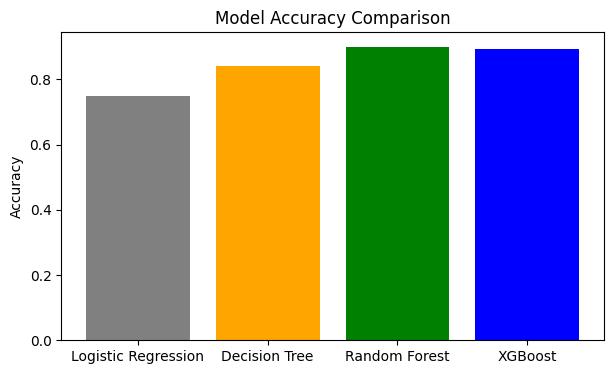


✅ Best Model Selected: Random Forest



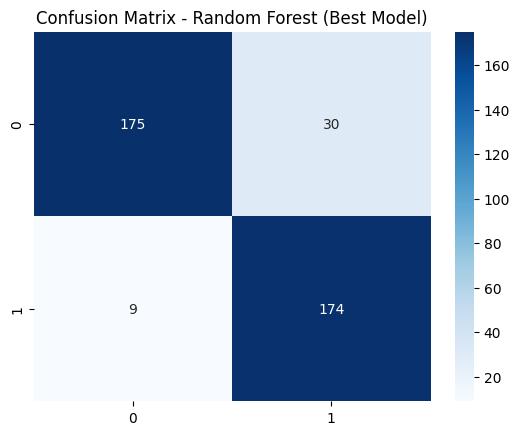

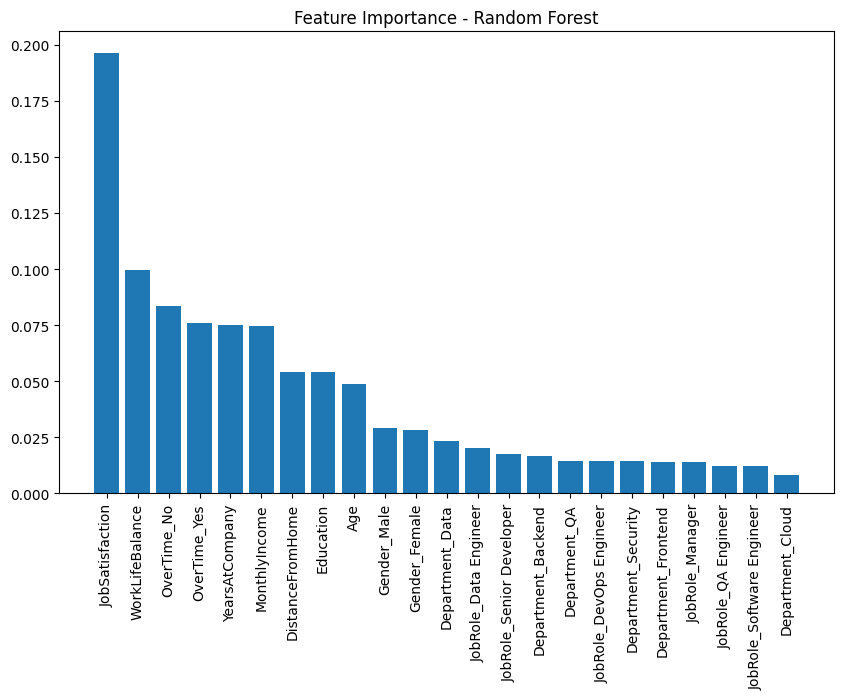


Final Prediction for  Employee → LIKELY to Leave ❌


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("/content/sample_data/employee_attrition_IT_1000.csv")


X = data.drop("Attrition", axis=1)
y = data["Attrition"].replace({"Yes": 1, "No": 0})


cat_cols = X.select_dtypes(include="object").columns.tolist()
preprocess = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)


X_processed = preprocess.fit_transform(X)


smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_processed, y)

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.25, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=400),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=350, learning_rate=0.09, max_depth=6,
                             subsample=0.9, colsample_bytree=0.9, random_state=42)
}

accuracy_scores = {}

print("\n================ MODEL PERFORMANCE COMPARISON ================\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracy_scores[name] = acc

    print(f"\n----- {name} -----")
    print("Accuracy:", acc)
    print(classification_report(y_test, preds))


plt.figure(figsize=(7,4))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['gray','orange','green','blue'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

best_model_name = max(accuracy_scores, key=accuracy_scores.get)
best_model = models[best_model_name]

print(f"\n✅ Best Model Selected: {best_model_name}\n")

best_model.fit(X_train, y_train)


best_preds = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name} (Best Model)")
plt.show()

encoded_cols = preprocess.transformers_[0][1].get_feature_names_out(cat_cols)
num_cols = X.select_dtypes(exclude='object').columns
all_features = np.concatenate([encoded_cols, num_cols])

if best_model_name == "Random Forest":
    importances = best_model.feature_importances_
else:  # XGBoost also works here
    importances = best_model.feature_importances_

sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(all_features[sorted_idx], importances[sorted_idx])
plt.xticks(rotation=90)
plt.title(f"Feature Importance - {best_model_name}")
plt.show()

# --------------- FINAL PREDICTION FUNCTION ------------------
def predict_employee(data_row):
    df = pd.DataFrame([data_row])
    df_enc = preprocess.transform(df)
    pred = best_model.predict(df_enc)[0]
    return "LIKELY to Leave ❌" if pred == 1 else "NOT Likely to Leave ✅"

# Example Prediction
new_emp = {
    "Age": 29,
    "Gender": "Male",
    "Department": "Backend",
    "Education": 3,
    "JobRole": "Software Engineer",
    "MonthlyIncome": 45000,
    "DistanceFromHome": 12,
    "YearsAtCompany": 1,
    "JobSatisfaction": 2,
    "WorkLifeBalance": 2,
    "OverTime": "Yes"
}

print("\nFinal Prediction for  Employee →", predict_employee(new_emp))
